In [63]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [77]:
## find signal with high seizure vote
metadata[metadata['expert_consensus'] == 'Seizure']

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
5,2161044411,3,22.0,983335548,3,22.0,3235853606,39251,Seizure,3,0,0,0,0,0
6,740996715,5,40.0,1428271696,5,40.0,2393090400,7283,Seizure,3,0,0,0,0,0
10,2655435410,10,82.0,1868716316,10,82.0,2064713930,24305,Seizure,3,0,0,0,0,0
20,924871605,21,108.0,707210069,21,108.0,4108410483,3596,Seizure,3,0,0,0,0,0
25,1735082541,8,42.0,26635579,8,42.0,4077460480,26091,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,3883443135,3,16.0,1783124126,3,16.0,2389716725,35946,Seizure,3,0,0,0,0,0
978,1735082541,1,6.0,26635579,1,6.0,2256315638,26091,Seizure,3,0,0,0,0,0
980,2842525354,14,140.0,215559912,14,140.0,540584599,10475,Seizure,3,0,0,0,0,0
983,1057856283,1,40.0,1506263931,1,40.0,3244710151,61701,Seizure,3,0,0,0,0,0


In [64]:
# Load into Dask
import dask.dataframe as dd
import numpy as np
import glob

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
            ]
sfreq = 200
eeg_ids = metadata['eeg_id'].to_list()

ddf_list = []
for eeg_id in eeg_ids:
  f_name = f'data/eeg/{eeg_id}.parquet'
  temp_ddf = dd.read_parquet(f_name).drop('EKG', axis=1)[channel_order]
  temp_ddf['eeg_id'] = str(eeg_id)
  temp_ddf = temp_ddf.set_index('eeg_id')
  ddf_list.append(temp_ddf)

ddf = dd.concat(ddf_list)
ddf


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
npartitions=1000,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [78]:
sig1 = ddf.loc['2161044411'].compute()
sig1

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
2161044411,-4.990000,1.080000,36.369999,38.619999,20.420000,12.780000,-7.110000,26.900000,16.740000,12.02,-10.150000,30.350000,19.709999,-45.099998,0.530000,-4.360000,-16.740000,-25.250000,-11.820000
2161044411,-8.370000,-8.270000,34.750000,26.770000,9.920000,-2.990000,-14.990000,-14.420000,1.290000,-0.29,-25.510000,22.200001,-0.790000,-56.259998,-10.000000,-13.280000,-23.160000,-32.880001,-18.370001
2161044411,-21.330000,-16.969999,11.280000,17.570000,-1.770000,-13.180000,-21.129999,13.460000,-11.670000,-10.41,-32.599998,15.000000,-11.220000,-64.160004,-17.889999,-20.670000,-28.570000,-39.419998,-25.190001
2161044411,-24.629999,-15.810000,14.430000,3.310000,-2.780000,-11.130000,-20.280001,46.669998,-34.200001,-10.58,-31.580000,16.480000,-16.330000,-67.500000,-18.520000,-19.030001,-26.760000,-38.450001,-24.690001
2161044411,-11.920000,-16.430000,53.830002,14.350000,1.120000,-12.720000,-25.570000,43.470001,-37.750000,-9.70,-34.330002,12.290000,-14.730000,-69.379997,-18.480000,-22.090000,-29.139999,-42.130001,-25.360001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161044411,4.140000,66.199997,49.080002,38.450001,19.770000,49.560001,14.240000,110.129997,21.420000,7.18,-19.959999,82.129997,118.800003,-7.350000,13.990000,-4.540000,-27.879999,-35.990002,-18.440001
2161044411,-2.330000,25.850000,31.440001,9.480000,8.530000,16.730000,8.510000,84.879997,11.390000,-2.26,-17.290001,79.260002,103.970001,-18.889999,8.190000,1.130000,-4.010000,-46.700001,-16.150000
2161044411,12.400000,49.529999,46.630001,16.400000,17.370001,42.180000,24.100000,86.029999,28.450001,9.74,-13.860000,93.599998,108.610001,-10.400000,17.160000,8.990000,3.950000,-41.369999,-5.970000


In [79]:
## MNE setup
import mne

mne_info = mne.create_info(ch_names=sig1.columns.tolist(), sfreq=200, ch_types='eeg')
mne_info.set_montage('standard_1020')
    
sig1_data = np.array(sig1.transpose())
sig1_data = np.nan_to_num(sig1_data)
    
raw = mne.io.RawArray(sig1_data, mne_info)
raw.apply_function(lambda x: x / 20e6, picks='eeg')

Creating RawArray with float64 data, n_channels=19, n_times=14800
    Range : 0 ... 14799 =      0.000 ...    73.995 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


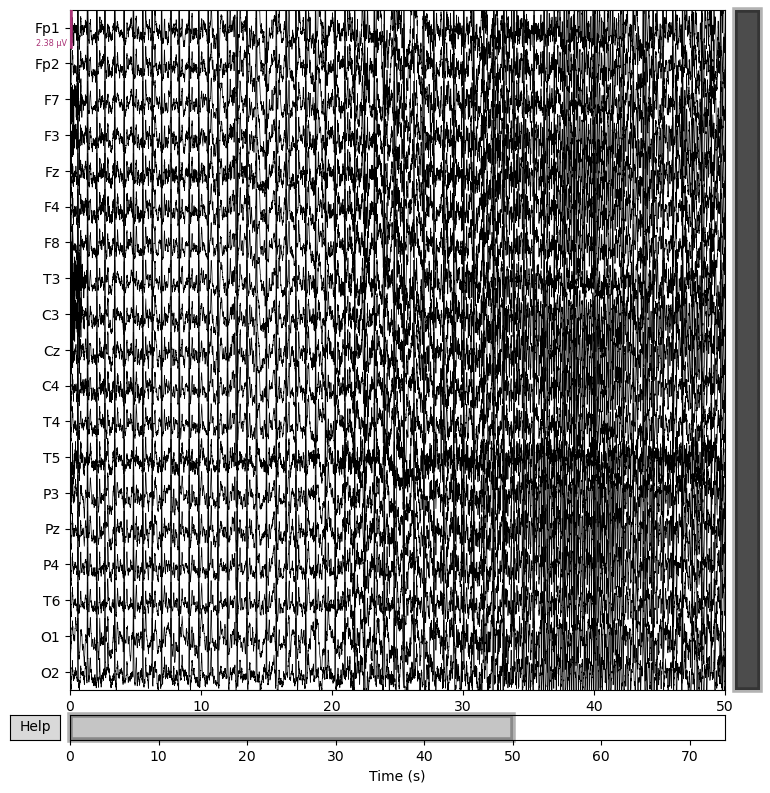

In [95]:
raw.plot(duration=50, proj=False, scalings={'eeg': 'auto'}, n_channels=len(raw.ch_names), remove_dc=False);

# Preprocessing
We must implement preprocessing techniques in order to remove artifacts

## Power Line Artifacts
The power line artifact occurs at 60Hz and can be seen in the plot below. To remove this, we can apply a notch filter

In [109]:
import matplotlib.pyplot as plt
#raw.plot(duration=50, n_channels=19, proj=False, remove_dc=False);
def add_arrows(axes):
  for ax in axes:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    freq = 60
    idx = np.searchsorted(freqs, freq)
    y = psds[(idx-4) : (idx+5)].max()
    ax.arrow(
      x=freqs[idx],
      y=y + 18,
      dx=0,
      dy=-12,
      color="red",
      width=0.1,
      head_width=3,
      length_includes_head=True,
    )

psd = raw.compute_psd();
fig = psd.plot(average=True, picks="data", exclude="bads");
add_arrows(fig.axes[:2]);


Effective window size : 10.240 (s)


/Users/gagetylee/anaconda3/envs/340-project/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


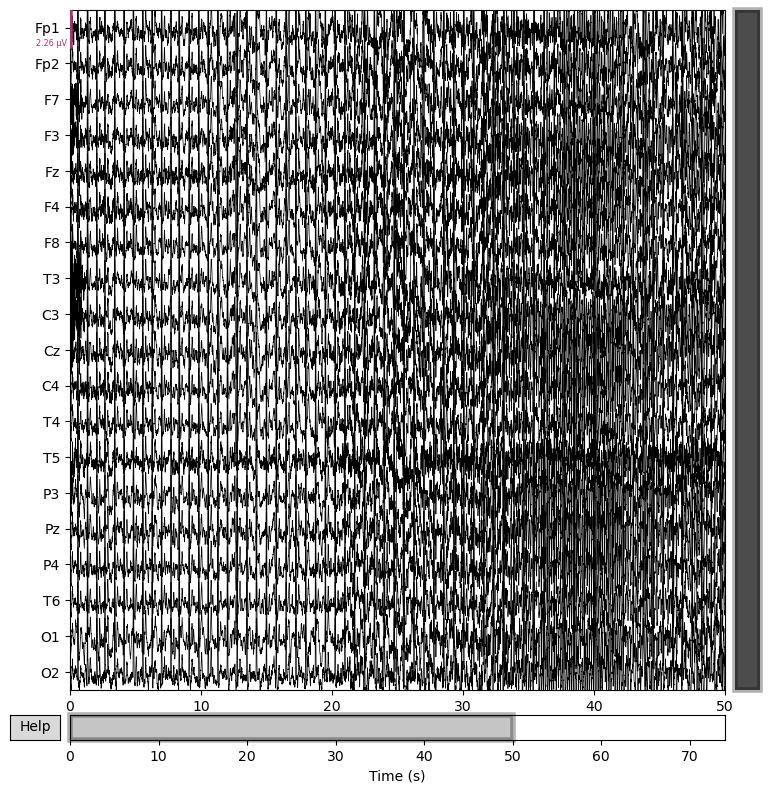

In [111]:
# Apply filter
from src.preprocessing import notch_filter

l_freq = 1.0
h_freq = 70.0

raw = raw.filter(l_freq, h_freq, method='fir')
raw_notch = notch_filter(raw, 60);
raw.plot(start=0, duration=50, proj=False, scalings={'eeg': 'auto'}, n_channels=len(raw.ch_names), remove_dc=False);

In [ ]:
from mne.decoding import Scaler

data = df.to_numpy()

scaler = Scaler(scalings='mean')
scaled = scaler.fit_transform(data.reshape(1, *data.shape))
scaled = scaled.reshape(data.shape)
df_scaled = pd.DataFrame(scaled, index = df.index, columns = df.columns)
df_scaled